In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 

In [26]:
# Connect to the SQLite database file
conn = sqlite3.connect('/mnt/data/public/us-wildfires/FPA_FOD_20170508.sqlite')

# Read a table into a Pandas DataFrame (replace `your_table_name` with the actual table name)
query = """
SELECT DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE, CONT_TIME, FIRE_SIZE_CLASS
FROM Fires
WHERE STATE = "OR"
"""
df = pd.read_sql_query(query, conn)

# Convert the time into a datetime format
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], origin='julian', unit='D')
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'], origin='julian', unit='D')
df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format="%H%M").dt.time
df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format="%H%M").dt.time

# Drop rows that do not have time
df.dropna(inplace = True)

# Combine the date and time into a single datetime
df["DISCOVERY_DATETIME"] = df.apply(
    lambda row: pd.Timestamp.combine(row["DISCOVERY_DATE"], row["DISCOVERY_TIME"]), axis=1
)
df["CONT_DATETIME"] = df.apply(
    lambda row: pd.Timestamp.combine(row["CONT_DATE"], row["CONT_TIME"]), axis=1
)

# Get the difference between how long the fire was discovered and contained
df['LENGTH_CONTAINED'] = df["CONT_DATETIME"] - df["DISCOVERY_DATETIME"]
df["LENGTH_HOURS"] = df["LENGTH_CONTAINED"].dt.total_seconds() / 3600  

# Get only the necessary features
features = ['FIRE_SIZE_CLASS', 'LENGTH_CONTAINED', 'LENGTH_HOURS']
features_df = df[features]
features_df


,FIRE_SIZE_CLASS,LENGTH_CONTAINED,LENGTH_HOURS
0,A,1 days 02:43:00,26.716667
1,A,0 days 00:25:00,0.416667
2,A,0 days 00:05:00,0.083333
3,B,0 days 04:01:00,4.016667
4,A,0 days 00:25:00,0.416667
...,...,...,...
61081,A,0 days 01:00:00,1.000000
61082,A,0 days 14:00:00,14.000000
61083,A,0 days 01:00:00,1.000000
61084,A,0 days 21:00:00,21.000000


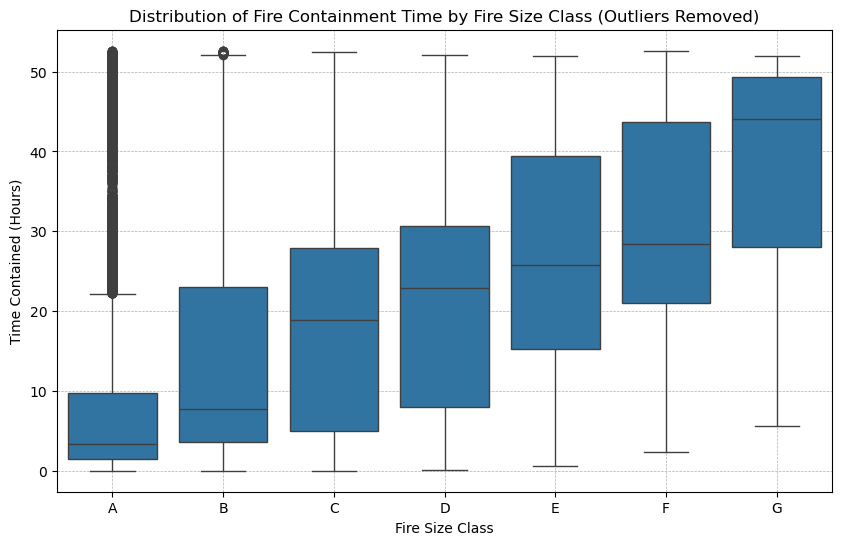

In [30]:
# Convert Timedelta to hours
df["LENGTH_HOURS"] = df["LENGTH_CONTAINED"].dt.total_seconds() / 3600

# Compute Q1, Q3, and IQR
Q1 = df["LENGTH_HOURS"].quantile(0.25)
Q3 = df["LENGTH_HOURS"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_filtered = df[(df["LENGTH_HOURS"] >= lower_bound) & (df["LENGTH_HOURS"] <= upper_bound)]

# Create the boxplot without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x="FIRE_SIZE_CLASS", y="LENGTH_HOURS", data=df_filtered)

# Customize labels
plt.xlabel("Fire Size Class")
plt.ylabel("Time Contained (Hours)")
plt.title("Distribution of Fire Containment Time by Fire Size Class (Outliers Removed)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


<Axes: xlabel='FIRE_SIZE_CLASS', ylabel='LENGTH_HOURS'>

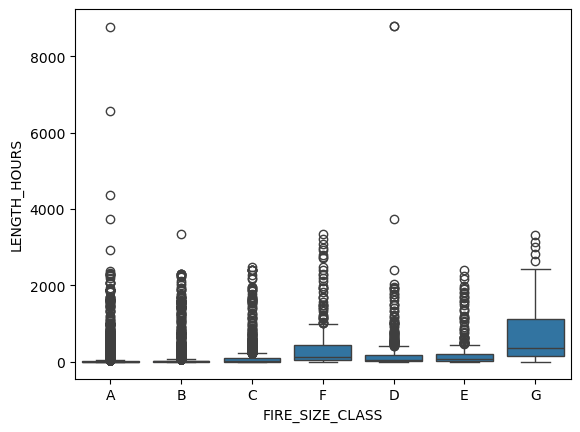

In [31]:
sns.boxplot(x="FIRE_SIZE_CLASS", y="LENGTH_HOURS", data=df)

In [ ]:
how to rem